# torch.nn 
## - (https://pytorch.org/docs/stable/nn.html)

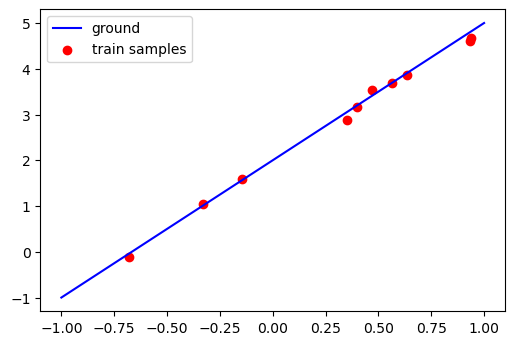

In [45]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from misc import *

import torch.nn as nn
import torch.optim as optim

from tqdm.auto import tqdm, trange

# device = torch.device('cuda:0')
device = torch.device('cpu')


def ground(x):
    y = 3*x + 2
    return y
    
Ntr = 10
noise = 1e-1
    
Xtr = np.random.uniform(-1,1, size=[Ntr,1])
ytr = ground(Xtr)
epsi = noise*np.random.normal(size=ytr.shape)

ytr = ytr+epsi

Xte = np.linspace(-1,1,100).reshape([-1,1])
yte = ground(Xte)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.squeeze(), yte.squeeze(), color='b', label='ground')
plt.scatter(Xtr.squeeze(), ytr.squeeze(), color='r', label='train samples')
plt.legend()


In [19]:

class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return self.X[index,:], self.y[index,:]

    def __len__(self,):
        return self.X.shape[0]
        
dataset_train = SimpleDataset(Xtr, ytr)
dataset_test = SimpleDataset(Xte, yte)


In [37]:

class LinearRegressor(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinearRegressor, self).__init__()  
        self.linear = nn.Linear(in_features=in_dim, out_features=out_dim)
    
    def forward(self, X):
        return self.linear(X)
    
model = LinearRegressor(in_dim=1, out_dim=1).to(device)

train_loader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

epochs=1000
lr=1e-2
reg=1e-5

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

hist_rmse_tr = []
hist_rmse_te = []
hist_pred_te = []

for ie in tqdm(range(epochs+1)):
    
    Xtr, ytr = next(iter(train_loader))
    Xte, yte = next(iter(test_loader))
    
    Xtr, ytr, Xte, yte = \
        Xtr.float().to(device), ytr.float().to(device), Xte.float().to(device), yte.float().to(device)
    
    pred = model(Xtr)
    loss = torch.mean(torch.square(pred-ytr))
    
    # step 1: clear the grads
    optimizer.zero_grad()
    # step 2: backward the computational graph
    loss.backward()
    # step 3: take the gradient step
    optimizer.step()
    
    if ie%50 == 0:
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        with torch.no_grad():
            rmse_tr = torch.sqrt(torch.mean(torch.square(ytr-pred)))
            rmse_te = torch.sqrt(torch.mean(torch.square(yte-model(Xte))))
            print('train_rmse={:.5f}, test_rmse={:.5f}'.format(rmse_tr.item(), rmse_te.item()))
            
            hist_rmse_tr.append(rmse_tr.item())
            hist_rmse_te.append(rmse_te.item())
            hist_pred_te.append(model(Xte).data.cpu().numpy())
        #
    #
#

hist_rmse_tr = np.array(hist_rmse_tr)
hist_rmse_te = np.array(hist_rmse_te)
hist_pred_te = np.array(hist_pred_te)        

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch #0	: train_rmse=1.20763, test_rmse=2.81593
Epoch #50	: train_rmse=0.94815, test_rmse=2.27657
Epoch #100	: train_rmse=0.72120, test_rmse=1.76105
Epoch #150	: train_rmse=0.53132, test_rmse=1.32578
Epoch #200	: train_rmse=0.37909, test_rmse=0.97331
Epoch #250	: train_rmse=0.26354, test_rmse=0.70072
Epoch #300	: train_rmse=0.18206, test_rmse=0.50018
Epoch #350	: train_rmse=0.13045, test_rmse=0.36025
Epoch #400	: train_rmse=0.10258, test_rmse=0.26773
Epoch #450	: train_rmse=0.09030, test_rmse=0.20980
Epoch #500	: train_rmse=0.08586, test_rmse=0.17540
Epoch #550	: train_rmse=0.08448, test_rmse=0.15601
Epoch #600	: train_rmse=0.08410, test_rmse=0.14563
Epoch #650	: train_rmse=0.08401, test_rmse=0.14035
Epoch #700	: train_rmse=0.08399, test_rmse=0.13779
Epoch #750	: train_rmse=0.08398, test_rmse=0.13662
Epoch #800	: train_rmse=0.08398, test_rmse=0.13611
Epoch #850	: train_rmse=0.08398, test_rmse=0.13590
Epoch #900	: train_rmse=0.08398, test_rmse=0.13582
Epoch #950	: train_rmse=0.08398, t

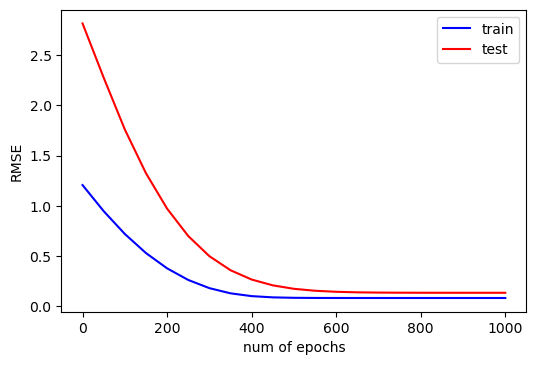

In [44]:
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
hist = np.arange(hist_rmse_tr.size)*50

plt.plot(hist, hist_rmse_tr, color='b', label='train')
plt.plot(hist, hist_rmse_te, color='r', label='test')
plt.xlabel('num of epochs')
plt.ylabel('RMSE')
plt.legend()

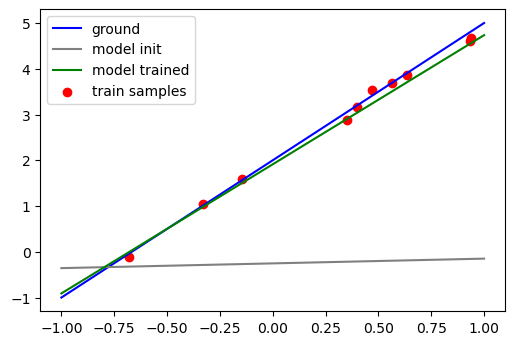

In [50]:
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(Xte.squeeze(), yte.squeeze(), color='b', label='ground')
plt.scatter(Xtr.squeeze(), ytr.squeeze(), color='r', label='train samples')
plt.plot(Xte.squeeze(), hist_pred_te[0,:].squeeze(), color='dimgray', label='model init')
plt.plot(Xte.squeeze(), hist_pred_te[-1,:].squeeze(), color='green', label='model trained')
plt.legend()